In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )
    def forward(self, x):
        return self.conv1(x)
    
class DwSepConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = BasicConv(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = BasicConv(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [11]:
class MobileNetV1(nn.Module):
    def __init__(self, alpha, num_classes=10, init_weight=True):
        super().__init__()

        self.alpha = alpha
        # 32*32 CIFAR IMG
        self.stem = BasicConv(3, int(32*self.alpha), kernel_size=3, stride=1, padding=1)
        # 224*224 IMG
        #self.stem = BasicConv(3, int(32*self.alpha), kernel_size=3, stride=2, padding=1)

        self.model = nn.Sequential(
            DwSepConv(int(32*self.alpha), int(64*self.alpha)),
            DwSepConv(int(64*self.alpha), int(128*self.alpha),stride=2),
            DwSepConv(int(128*self.alpha), int(128*self.alpha)),
            DwSepConv(int(128*self.alpha), int(256*self.alpha), stride=2),
            DwSepConv(int(256*self.alpha), int(256*self.alpha)),
            DwSepConv(int(256*self.alpha), int(512*self.alpha), stride=2),
            # 5층에서->3개층으로 줄임 CIFAR-10
            *[DwSepConv(int(512 * self.alpha), int(512 * self.alpha)) for _ in range(3)],
            DwSepConv(int(512*self.alpha), int(1024*self.alpha), stride=2),
            DwSepConv(int(1024*self.alpha), int(1024*self.alpha))
        )
        self.classfier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(int(1024*self.alpha), num_classes)
        )
        if init_weight: #초기화 구동함수 호출
            self._initialize_weight()
    def forward(self, x):
        x = self.stem(x)
        x = self.model(x)
        x = self.classfier(x)

        return x
    
    #모델의 초기 Random을 커스터마이징 하기 위한 함수
    def _initialize_weight(self):
        for m in self.modules(): #설계한 모델의 모든 레이어를 순회
            if isinstance(m, nn.Conv2d): #conv의 파라미터(weight, bias)의 초가깂설정
                # Kaiming 초기화를 사용한 이유:
                # Kaiming 초기화는 ReLU 활성화 함수와 함께 사용될 때 좋은 성능을 보임
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d): #BN의 파라미터(weight, bias)의 초가깂설정
                # BatchNorm 레이어의 가중치와 바이어스를 간단한 값으로 초기화
                nn.init.constant_(m.weight, 1) # 1로 다 채움
                nn.init.constant_(m.bias, 0) # 0으로 다 채움

            elif isinstance(m, nn.Linear): #FCL의 파라미터(weight, bias)의 초기값 설정
                # 선형 레이어의 가중치를 정규 분포로 초기화
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [12]:
model = MobileNetV1(alpha = 1)
summary(model, input_size = (2, 3, 224, 224), device = "cpu")

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV1                                   [2, 10]                   --
├─BasicConv: 1-1                              [2, 32, 224, 224]         --
│    └─Sequential: 2-1                        [2, 32, 224, 224]         --
│    │    └─Conv2d: 3-1                       [2, 32, 224, 224]         864
│    │    └─BatchNorm2d: 3-2                  [2, 32, 224, 224]         64
│    │    └─ReLU6: 3-3                        [2, 32, 224, 224]         --
├─Sequential: 1-2                             [2, 1024, 14, 14]         --
│    └─DwSepConv: 2-2                         [2, 64, 224, 224]         --
│    │    └─BasicConv: 3-4                    [2, 32, 224, 224]         352
│    │    └─BasicConv: 3-5                    [2, 64, 224, 224]         2,176
│    └─DwSepConv: 2-3                         [2, 128, 112, 112]        --
│    │    └─BasicConv: 3-6                    [2, 64, 112, 112]         704
│    │    └─Ba

In [13]:
# CUDA 또는 CPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델을 CUDA 또는 CPU로 이동
model.to(device)

Using device: cuda


MobileNetV1(
  (stem): BasicConv(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
  (model): Sequential(
    (0): DwSepConv(
      (depthwise): BasicConv(
        (conv1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
      (pointwise): BasicConv(
        (conv1): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): DwSepConv(
      (depthwise): BasicConv(
        (conv1): Sequential

In [14]:
def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        
    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size
    
    # Train Error Rate 계산
    train_error_rate = 100 * (1 - avg_accuracy)
    
    # Train Error Rate 출력 (epoch_step에 따라)
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f'Train Error Rate: {train_error_rate:.2f}%')

    return avg_loss, avg_accuracy, train_error_rate

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        
        # Test Error Rate 계산
        test_error_rate = 100 * (1 - accuracy)
        
        # Test Error Rate 출력 (epoch_step에 따라)
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            print(f'Test Error Rate: {test_error_rate:.2f}%')
        
        return loss, accuracy, test_error_rate

In [15]:
# 하이퍼파라미터 설정
initial_learning_rate = 0.001
num_epochs = 100
epoch_step = 10

# 실험 설정
experiments = [
    {'alpha': 1, 'rho': 224},
    {'alpha': 1, 'rho': 128},
#     {'alpha': 0.75, 'rho': 224},
#     {'alpha': 0.75, 'rho': 128},
#     {'alpha': 0.25, 'rho': 224},
#     {'alpha': 0.25, 'rho': 128},
]

# 실험 결과를 저장할 리스트 초기화
all_experiment_results = []

# 실험 루프
for experiment in experiments:
    alpha = experiment['alpha']
    rho = experiment['rho']
    
    print(f"Starting experiment with alpha={alpha}, rho={rho}")
    # 데이터 증강
    train_transforms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    path = '/kaggle/working/data'
    if not os.path.exists(path):
        os.mkdir(path)

    # 데이터 로더
    trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transforms)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root=path, train=False, download=True, transform=val_transforms)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    # 모델, 손실함수, 옵티마이저 초기화
    model = MobileNetV1(alpha=alpha).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # 학습 및 평가
    loss, accuracy, train_error_rates, test_error_rates = [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_error_rate = model_train(model, train_loader, criterion, optimizer, epoch)
        test_loss, test_accuracy, test_error_rate = model_eval(model, test_loader, criterion, epoch)

        loss.append([train_loss, test_loss])
        accuracy.append([train_accuracy, test_accuracy])
        train_error_rates.append(train_error_rate)
        test_error_rates.append(test_error_rate)

        scheduler.step()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            print(f"epoch {epoch+1:03d}, Training loss: " + 
                  f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
            print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")
            print(f"Train error rate: {train_error_rate:.2f}%, Test error rate: {test_error_rate:.2f}%")

    # 실험 결과 저장
    experiment_results = {
        'alpha': alpha,
        'rho': rho,
        'loss': loss,
        'accuracy': accuracy,
        'train_error_rates': train_error_rates,
        'test_error_rates': test_error_rates,
    }
    all_experiment_results.append(experiment_results)
    
    print(f"Experiment with alpha={alpha}, rho={rho} completed.\n")


Starting experiment with alpha=1, rho=224
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.9871, accuracy: 0.2786: 100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


Train Error Rate: 72.14%


100%|██████████| 79/79 [00:01<00:00, 51.14it/s]

Test Error Rate: 60.27%
epoch 001, Training loss: 1.9871, Training accuracy: 0.2786
Test loss: 1.6079, Test accuracy: 0.3973
Train error rate: 72.14%, Test error rate: 60.27%



[Training] loss: 0.9168, accuracy: 0.6843: 100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


Train Error Rate: 31.57%


100%|██████████| 79/79 [00:01<00:00, 50.28it/s]

Test Error Rate: 42.26%
epoch 010, Training loss: 0.9168, Training accuracy: 0.6843
Test loss: 1.3994, Test accuracy: 0.5774
Train error rate: 31.57%, Test error rate: 42.26%



[Training] loss: 0.8323, accuracy: 0.7176: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s]


Train Error Rate: 28.24%


100%|██████████| 79/79 [00:01<00:00, 48.44it/s]

Test Error Rate: 29.57%
epoch 020, Training loss: 0.8323, Training accuracy: 0.7176
Test loss: 0.8673, Test accuracy: 0.7043
Train error rate: 28.24%, Test error rate: 29.57%



[Training] loss: 0.7886, accuracy: 0.7345: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]


Train Error Rate: 26.55%


100%|██████████| 79/79 [00:01<00:00, 50.48it/s]

Test Error Rate: 29.12%
epoch 030, Training loss: 0.7886, Training accuracy: 0.7345
Test loss: 0.8604, Test accuracy: 0.7088
Train error rate: 26.55%, Test error rate: 29.12%



[Training] loss: 0.7598, accuracy: 0.7434: 100%|██████████| 391/391 [00:23<00:00, 16.29it/s]


Train Error Rate: 25.66%


100%|██████████| 79/79 [00:01<00:00, 49.80it/s]

Test Error Rate: 30.21%
epoch 040, Training loss: 0.7598, Training accuracy: 0.7434
Test loss: 0.9253, Test accuracy: 0.6979
Train error rate: 25.66%, Test error rate: 30.21%



[Training] loss: 0.7309, accuracy: 0.7522: 100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


Train Error Rate: 24.78%


100%|██████████| 79/79 [00:01<00:00, 51.29it/s]

Test Error Rate: 28.25%
epoch 050, Training loss: 0.7309, Training accuracy: 0.7522
Test loss: 0.8339, Test accuracy: 0.7175
Train error rate: 24.78%, Test error rate: 28.25%



[Training] loss: 0.7070, accuracy: 0.7612: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]


Train Error Rate: 23.88%


100%|██████████| 79/79 [00:01<00:00, 50.89it/s]

Test Error Rate: 26.38%
epoch 060, Training loss: 0.7070, Training accuracy: 0.7612
Test loss: 0.8056, Test accuracy: 0.7362
Train error rate: 23.88%, Test error rate: 26.38%



[Training] loss: 0.6904, accuracy: 0.7669: 100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


Train Error Rate: 23.31%


100%|██████████| 79/79 [00:01<00:00, 48.86it/s]

Test Error Rate: 28.67%
epoch 070, Training loss: 0.6904, Training accuracy: 0.7669
Test loss: 0.8817, Test accuracy: 0.7133
Train error rate: 23.31%, Test error rate: 28.67%



[Training] loss: 0.6737, accuracy: 0.7729: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]


Train Error Rate: 22.71%


100%|██████████| 79/79 [00:01<00:00, 50.99it/s]


Test Error Rate: 23.44%
epoch 080, Training loss: 0.6737, Training accuracy: 0.7729
Test loss: 0.6891, Test accuracy: 0.7656
Train error rate: 22.71%, Test error rate: 23.44%


[Training] loss: 0.6502, accuracy: 0.7794: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]


Train Error Rate: 22.06%


100%|██████████| 79/79 [00:01<00:00, 48.33it/s]

Test Error Rate: 23.17%
epoch 090, Training loss: 0.6502, Training accuracy: 0.7794
Test loss: 0.6866, Test accuracy: 0.7683
Train error rate: 22.06%, Test error rate: 23.17%



[Training] loss: 0.6356, accuracy: 0.7865: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]


Train Error Rate: 21.35%


100%|██████████| 79/79 [00:01<00:00, 49.94it/s]


Test Error Rate: 25.64%
epoch 100, Training loss: 0.6356, Training accuracy: 0.7865
Test loss: 0.8063, Test accuracy: 0.7436
Train error rate: 21.35%, Test error rate: 25.64%
Experiment with alpha=1, rho=224 completed.

Starting experiment with alpha=1, rho=128
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.9352, accuracy: 0.3064: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


Train Error Rate: 69.36%


100%|██████████| 79/79 [00:01<00:00, 47.12it/s]

Test Error Rate: 59.10%
epoch 001, Training loss: 1.9352, Training accuracy: 0.3064
Test loss: 1.5527, Test accuracy: 0.4090
Train error rate: 69.36%, Test error rate: 59.10%



[Training] loss: 0.9242, accuracy: 0.6855: 100%|██████████| 391/391 [00:23<00:00, 16.56it/s]


Train Error Rate: 31.45%


100%|██████████| 79/79 [00:01<00:00, 41.95it/s]

Test Error Rate: 40.56%
epoch 010, Training loss: 0.9242, Training accuracy: 0.6855
Test loss: 1.2028, Test accuracy: 0.5944
Train error rate: 31.45%, Test error rate: 40.56%



[Training] loss: 0.8271, accuracy: 0.7205: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]


Train Error Rate: 27.95%


100%|██████████| 79/79 [00:01<00:00, 47.56it/s]

Test Error Rate: 38.36%
epoch 020, Training loss: 0.8271, Training accuracy: 0.7205
Test loss: 1.3229, Test accuracy: 0.6164
Train error rate: 27.95%, Test error rate: 38.36%



[Training] loss: 0.7823, accuracy: 0.7359: 100%|██████████| 391/391 [00:23<00:00, 16.34it/s]


Train Error Rate: 26.41%


100%|██████████| 79/79 [00:01<00:00, 48.29it/s]

Test Error Rate: 26.30%
epoch 030, Training loss: 0.7823, Training accuracy: 0.7359
Test loss: 0.7861, Test accuracy: 0.7370
Train error rate: 26.41%, Test error rate: 26.30%



[Training] loss: 0.7341, accuracy: 0.7532: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]


Train Error Rate: 24.68%


100%|██████████| 79/79 [00:01<00:00, 46.49it/s]

Test Error Rate: 29.62%
epoch 040, Training loss: 0.7341, Training accuracy: 0.7532
Test loss: 0.9125, Test accuracy: 0.7038
Train error rate: 24.68%, Test error rate: 29.62%



[Training] loss: 0.7030, accuracy: 0.7617: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]


Train Error Rate: 23.83%


100%|██████████| 79/79 [00:01<00:00, 48.76it/s]

Test Error Rate: 36.52%
epoch 050, Training loss: 0.7030, Training accuracy: 0.7617
Test loss: 1.0970, Test accuracy: 0.6348
Train error rate: 23.83%, Test error rate: 36.52%



[Training] loss: 0.6839, accuracy: 0.7685: 100%|██████████| 391/391 [00:24<00:00, 16.09it/s]


Train Error Rate: 23.15%


100%|██████████| 79/79 [00:01<00:00, 47.89it/s]

Test Error Rate: 25.14%
epoch 060, Training loss: 0.6839, Training accuracy: 0.7685
Test loss: 0.7307, Test accuracy: 0.7486
Train error rate: 23.15%, Test error rate: 25.14%



[Training] loss: 0.6632, accuracy: 0.7761: 100%|██████████| 391/391 [00:23<00:00, 16.42it/s]


Train Error Rate: 22.39%


100%|██████████| 79/79 [00:01<00:00, 45.98it/s]

Test Error Rate: 22.59%
epoch 070, Training loss: 0.6632, Training accuracy: 0.7761
Test loss: 0.6694, Test accuracy: 0.7741
Train error rate: 22.39%, Test error rate: 22.59%



[Training] loss: 0.6419, accuracy: 0.7831: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]


Train Error Rate: 21.69%


100%|██████████| 79/79 [00:01<00:00, 51.60it/s]

Test Error Rate: 28.59%
epoch 080, Training loss: 0.6419, Training accuracy: 0.7831
Test loss: 0.8708, Test accuracy: 0.7141
Train error rate: 21.69%, Test error rate: 28.59%



[Training] loss: 0.6306, accuracy: 0.7874: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]


Train Error Rate: 21.26%


100%|██████████| 79/79 [00:01<00:00, 50.28it/s]

Test Error Rate: 29.74%
epoch 090, Training loss: 0.6306, Training accuracy: 0.7874
Test loss: 0.9222, Test accuracy: 0.7026
Train error rate: 21.26%, Test error rate: 29.74%



[Training] loss: 0.6141, accuracy: 0.7927: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]


Train Error Rate: 20.73%


100%|██████████| 79/79 [00:01<00:00, 49.94it/s]

Test Error Rate: 24.45%
epoch 100, Training loss: 0.6141, Training accuracy: 0.7927
Test loss: 0.7506, Test accuracy: 0.7555
Train error rate: 20.73%, Test error rate: 24.45%
Experiment with alpha=1, rho=128 completed.



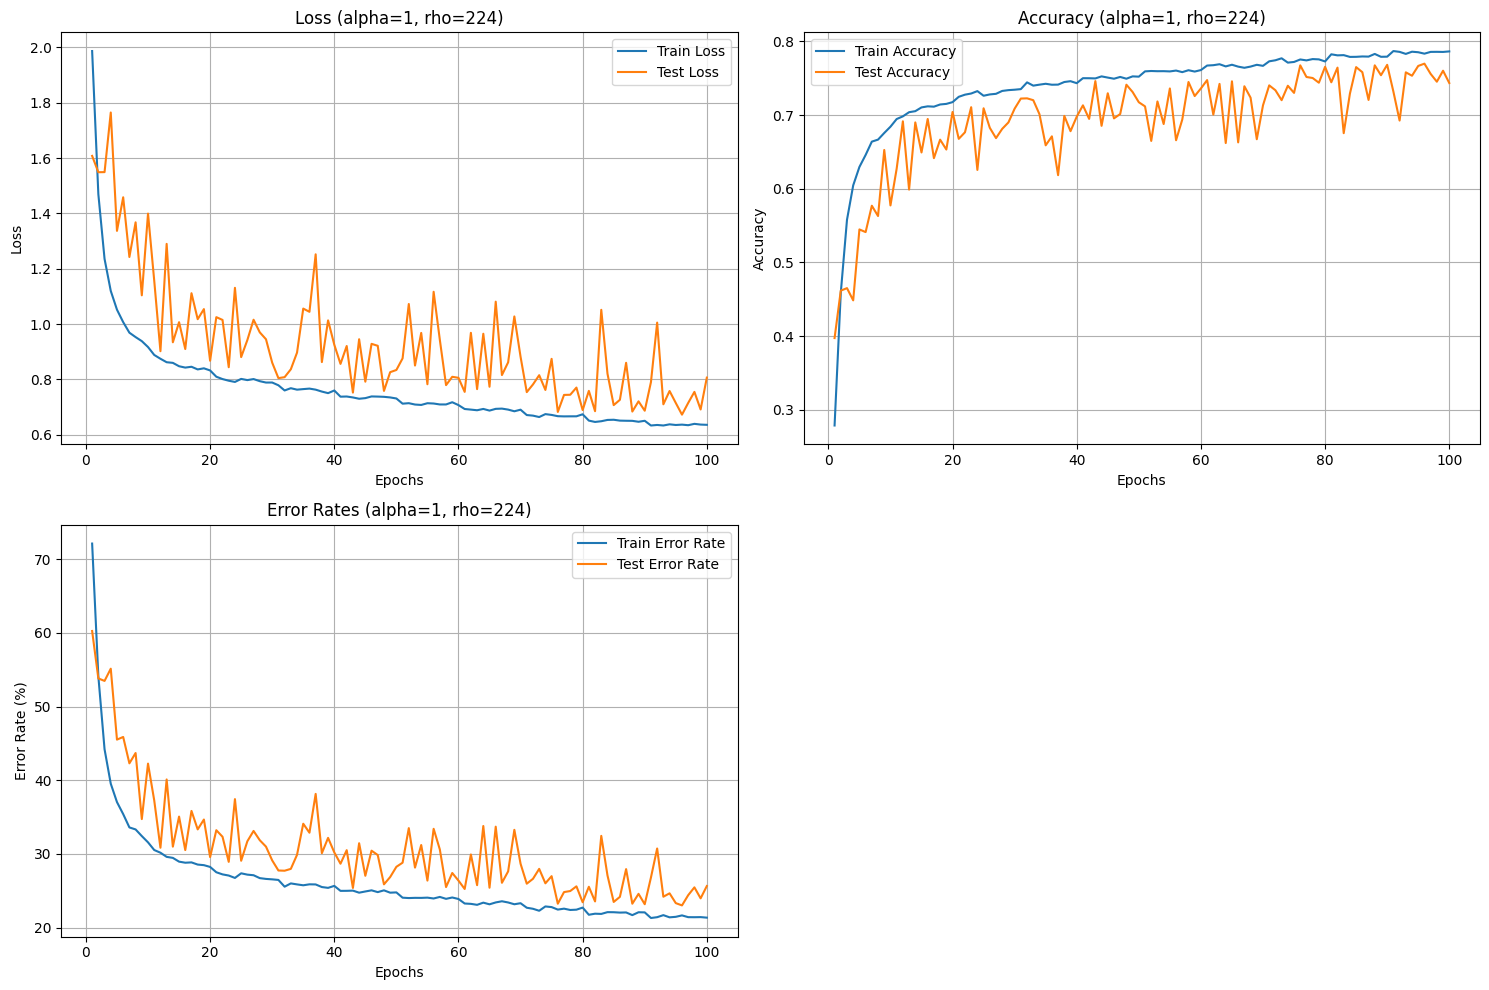

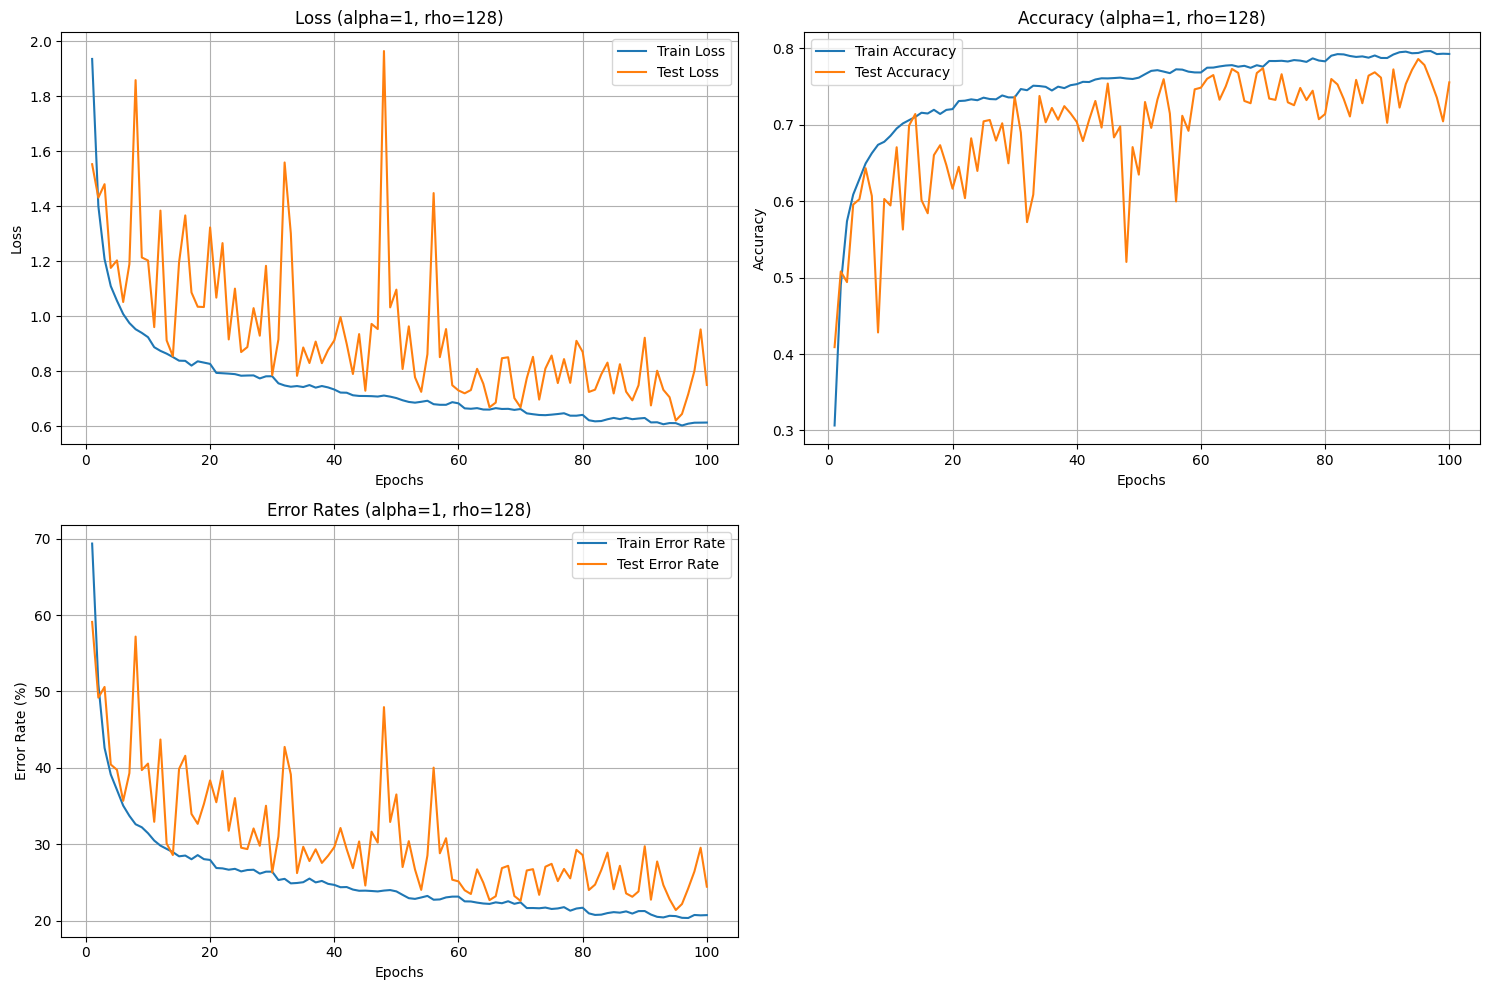

In [17]:
for result in all_experiment_results:
    alpha = result['alpha']
    rho = result['rho']
    loss = result['loss']
    accuracy = result['accuracy']
    train_error_rates = result['train_error_rates']
    test_error_rates = result['test_error_rates']
    
    train_loss, test_loss = zip(*loss)
    train_acc, test_acc = zip(*accuracy)
    
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Loss 그래프
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title(f'Loss (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy 그래프
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title(f'Accuracy (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Train & Test Error Rate 그래프
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_error_rates, label='Train Error Rate')
    plt.plot(epochs, test_error_rates, label='Test Error Rate')
    plt.title(f'Error Rates (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
# 하이퍼파라미터 설정
initial_learning_rate = 0.001
num_epochs = 100
epoch_step = 10

# 실험 설정
experiments = [
 #   {'alpha': 1, 'rho': 224},
#    {'alpha': 1, 'rho': 128},
    {'alpha': 0.75, 'rho': 224},
    {'alpha': 0.75, 'rho': 128},
    {'alpha': 0.25, 'rho': 128},
    {'alpha': 0.25, 'rho': 64},
]

# 실험 결과를 저장할 리스트 초기화
all_experiment_results = []

# 실험 루프
for experiment in experiments:
    alpha = experiment['alpha']
    rho = experiment['rho']
    
    print(f"Starting experiment with alpha={alpha}, rho={rho}")
    # 데이터 증강
    train_transforms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    path = '/kaggle/working/data'
    if not os.path.exists(path):
        os.mkdir(path)

    # 데이터 로더
    trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transforms)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root=path, train=False, download=True, transform=val_transforms)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    # 모델, 손실함수, 옵티마이저 초기화
    model = MobileNetV1(alpha=alpha).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # 학습 및 평가
    loss, accuracy, train_error_rates, test_error_rates = [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_error_rate = model_train(model, train_loader, criterion, optimizer, epoch)
        test_loss, test_accuracy, test_error_rate = model_eval(model, test_loader, criterion, epoch)

        loss.append([train_loss, test_loss])
        accuracy.append([train_accuracy, test_accuracy])
        train_error_rates.append(train_error_rate)
        test_error_rates.append(test_error_rate)

        scheduler.step()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            print(f"epoch {epoch+1:03d}, Training loss: " + 
                  f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
            print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")
            print(f"Train error rate: {train_error_rate:.2f}%, Test error rate: {test_error_rate:.2f}%")

    # 실험 결과 저장
    experiment_results = {
        'alpha': alpha,
        'rho': rho,
        'loss': loss,
        'accuracy': accuracy,
        'train_error_rates': train_error_rates,
        'test_error_rates': test_error_rates,
    }
    all_experiment_results.append(experiment_results)
    
    print(f"Experiment with alpha={alpha}, rho={rho} completed.\n")


Starting experiment with alpha=0.75, rho=224
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.7924, accuracy: 0.3514: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]


Train Error Rate: 64.86%


100%|██████████| 79/79 [00:01<00:00, 49.49it/s]

Test Error Rate: 61.11%
epoch 001, Training loss: 1.7924, Training accuracy: 0.3514
Test loss: 1.6715, Test accuracy: 0.3889
Train error rate: 64.86%, Test error rate: 61.11%



[Training] loss: 0.8934, accuracy: 0.6947: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


Train Error Rate: 30.53%


100%|██████████| 79/79 [00:01<00:00, 49.13it/s]

Test Error Rate: 38.56%
epoch 010, Training loss: 0.8934, Training accuracy: 0.6947
Test loss: 1.1269, Test accuracy: 0.6144
Train error rate: 30.53%, Test error rate: 38.56%



[Training] loss: 0.8117, accuracy: 0.7249: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]


Train Error Rate: 27.51%


100%|██████████| 79/79 [00:01<00:00, 48.60it/s]

Test Error Rate: 36.46%
epoch 020, Training loss: 0.8117, Training accuracy: 0.7249
Test loss: 1.2865, Test accuracy: 0.6354
Train error rate: 27.51%, Test error rate: 36.46%



[Training] loss: 0.7623, accuracy: 0.7447: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]


Train Error Rate: 25.53%


100%|██████████| 79/79 [00:01<00:00, 42.69it/s]

Test Error Rate: 35.67%
epoch 030, Training loss: 0.7623, Training accuracy: 0.7447
Test loss: 1.1469, Test accuracy: 0.6433
Train error rate: 25.53%, Test error rate: 35.67%



[Training] loss: 0.7391, accuracy: 0.7522: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]


Train Error Rate: 24.78%


100%|██████████| 79/79 [00:01<00:00, 49.47it/s]

Test Error Rate: 35.21%
epoch 040, Training loss: 0.7391, Training accuracy: 0.7522
Test loss: 1.1085, Test accuracy: 0.6479
Train error rate: 24.78%, Test error rate: 35.21%



[Training] loss: 0.6967, accuracy: 0.7633: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


Train Error Rate: 23.67%


100%|██████████| 79/79 [00:01<00:00, 49.06it/s]

Test Error Rate: 27.18%
epoch 050, Training loss: 0.6967, Training accuracy: 0.7633
Test loss: 0.8125, Test accuracy: 0.7282
Train error rate: 23.67%, Test error rate: 27.18%



[Training] loss: 0.6882, accuracy: 0.7675: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]


Train Error Rate: 23.25%


100%|██████████| 79/79 [00:01<00:00, 50.78it/s]

Test Error Rate: 26.37%
epoch 060, Training loss: 0.6882, Training accuracy: 0.7675
Test loss: 0.7882, Test accuracy: 0.7363
Train error rate: 23.25%, Test error rate: 26.37%



[Training] loss: 0.6653, accuracy: 0.7752: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Train Error Rate: 22.48%


100%|██████████| 79/79 [00:01<00:00, 48.77it/s]

Test Error Rate: 29.13%
epoch 070, Training loss: 0.6653, Training accuracy: 0.7752
Test loss: 0.8702, Test accuracy: 0.7087
Train error rate: 22.48%, Test error rate: 29.13%



[Training] loss: 0.6449, accuracy: 0.7815: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]


Train Error Rate: 21.85%


100%|██████████| 79/79 [00:01<00:00, 47.88it/s]

Test Error Rate: 24.32%
epoch 080, Training loss: 0.6449, Training accuracy: 0.7815
Test loss: 0.7200, Test accuracy: 0.7568
Train error rate: 21.85%, Test error rate: 24.32%



[Training] loss: 0.6288, accuracy: 0.7861: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]


Train Error Rate: 21.39%


100%|██████████| 79/79 [00:01<00:00, 49.89it/s]

Test Error Rate: 22.04%
epoch 090, Training loss: 0.6288, Training accuracy: 0.7861
Test loss: 0.6583, Test accuracy: 0.7796
Train error rate: 21.39%, Test error rate: 22.04%



[Training] loss: 0.6132, accuracy: 0.7934: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]


Train Error Rate: 20.66%


100%|██████████| 79/79 [00:01<00:00, 49.15it/s]


Test Error Rate: 19.60%
epoch 100, Training loss: 0.6132, Training accuracy: 0.7934
Test loss: 0.5810, Test accuracy: 0.8040
Train error rate: 20.66%, Test error rate: 19.60%
Experiment with alpha=0.75, rho=224 completed.

Starting experiment with alpha=0.75, rho=128
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.7843, accuracy: 0.3437: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]


Train Error Rate: 65.63%


100%|██████████| 79/79 [00:01<00:00, 49.83it/s]

Test Error Rate: 57.18%
epoch 001, Training loss: 1.7843, Training accuracy: 0.3437
Test loss: 1.5392, Test accuracy: 0.4282
Train error rate: 65.63%, Test error rate: 57.18%



[Training] loss: 0.9056, accuracy: 0.6861: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]


Train Error Rate: 31.39%


100%|██████████| 79/79 [00:01<00:00, 47.43it/s]

Test Error Rate: 47.96%
epoch 010, Training loss: 0.9056, Training accuracy: 0.6861
Test loss: 1.5739, Test accuracy: 0.5204
Train error rate: 31.39%, Test error rate: 47.96%



[Training] loss: 0.8230, accuracy: 0.7196: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]


Train Error Rate: 28.04%


100%|██████████| 79/79 [00:01<00:00, 48.27it/s]

Test Error Rate: 36.84%
epoch 020, Training loss: 0.8230, Training accuracy: 0.7196
Test loss: 1.1658, Test accuracy: 0.6316
Train error rate: 28.04%, Test error rate: 36.84%



[Training] loss: 0.7747, accuracy: 0.7345: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]


Train Error Rate: 26.55%


100%|██████████| 79/79 [00:01<00:00, 49.68it/s]

Test Error Rate: 37.06%
epoch 030, Training loss: 0.7747, Training accuracy: 0.7345
Test loss: 1.1823, Test accuracy: 0.6294
Train error rate: 26.55%, Test error rate: 37.06%



[Training] loss: 0.7454, accuracy: 0.7478: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]


Train Error Rate: 25.22%


100%|██████████| 79/79 [00:01<00:00, 46.99it/s]

Test Error Rate: 34.17%
epoch 040, Training loss: 0.7454, Training accuracy: 0.7478
Test loss: 1.2051, Test accuracy: 0.6583
Train error rate: 25.22%, Test error rate: 34.17%



[Training] loss: 0.7240, accuracy: 0.7550: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]


Train Error Rate: 24.50%


100%|██████████| 79/79 [00:01<00:00, 47.53it/s]

Test Error Rate: 29.01%
epoch 050, Training loss: 0.7240, Training accuracy: 0.7550
Test loss: 0.8452, Test accuracy: 0.7099
Train error rate: 24.50%, Test error rate: 29.01%



[Training] loss: 0.6923, accuracy: 0.7667: 100%|██████████| 391/391 [00:18<00:00, 20.72it/s]


Train Error Rate: 23.33%


100%|██████████| 79/79 [00:01<00:00, 49.73it/s]

Test Error Rate: 28.14%
epoch 060, Training loss: 0.6923, Training accuracy: 0.7667
Test loss: 0.8362, Test accuracy: 0.7186
Train error rate: 23.33%, Test error rate: 28.14%



[Training] loss: 0.6753, accuracy: 0.7696: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]


Train Error Rate: 23.04%


100%|██████████| 79/79 [00:01<00:00, 48.80it/s]

Test Error Rate: 25.58%
epoch 070, Training loss: 0.6753, Training accuracy: 0.7696
Test loss: 0.7692, Test accuracy: 0.7442
Train error rate: 23.04%, Test error rate: 25.58%



[Training] loss: 0.6456, accuracy: 0.7807: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]


Train Error Rate: 21.93%


100%|██████████| 79/79 [00:01<00:00, 49.12it/s]

Test Error Rate: 25.55%
epoch 080, Training loss: 0.6456, Training accuracy: 0.7807
Test loss: 0.7908, Test accuracy: 0.7445
Train error rate: 21.93%, Test error rate: 25.55%



[Training] loss: 0.6386, accuracy: 0.7834: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]


Train Error Rate: 21.66%


100%|██████████| 79/79 [00:01<00:00, 49.12it/s]

Test Error Rate: 27.39%
epoch 090, Training loss: 0.6386, Training accuracy: 0.7834
Test loss: 0.8627, Test accuracy: 0.7261
Train error rate: 21.66%, Test error rate: 27.39%



[Training] loss: 0.6128, accuracy: 0.7903: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]


Train Error Rate: 20.97%


100%|██████████| 79/79 [00:01<00:00, 50.06it/s]


Test Error Rate: 22.82%
epoch 100, Training loss: 0.6128, Training accuracy: 0.7903
Test loss: 0.6738, Test accuracy: 0.7718
Train error rate: 20.97%, Test error rate: 22.82%
Experiment with alpha=0.75, rho=128 completed.

Starting experiment with alpha=0.25, rho=128
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.8672, accuracy: 0.2999: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s]


Train Error Rate: 70.01%


100%|██████████| 79/79 [00:01<00:00, 46.34it/s]

Test Error Rate: 61.73%
epoch 001, Training loss: 1.8672, Training accuracy: 0.2999
Test loss: 1.6316, Test accuracy: 0.3827
Train error rate: 70.01%, Test error rate: 61.73%



[Training] loss: 1.0172, accuracy: 0.6448: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]


Train Error Rate: 35.52%


100%|██████████| 79/79 [00:01<00:00, 48.77it/s]

Test Error Rate: 41.69%
epoch 010, Training loss: 1.0172, Training accuracy: 0.6448
Test loss: 1.1955, Test accuracy: 0.5831
Train error rate: 35.52%, Test error rate: 41.69%



[Training] loss: 0.9178, accuracy: 0.6842: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]


Train Error Rate: 31.58%


100%|██████████| 79/79 [00:01<00:00, 49.36it/s]

Test Error Rate: 42.05%
epoch 020, Training loss: 0.9178, Training accuracy: 0.6842
Test loss: 1.2212, Test accuracy: 0.5795
Train error rate: 31.58%, Test error rate: 42.05%



[Training] loss: 0.8752, accuracy: 0.6994: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s]


Train Error Rate: 30.06%


100%|██████████| 79/79 [00:01<00:00, 46.61it/s]

Test Error Rate: 38.03%
epoch 030, Training loss: 0.8752, Training accuracy: 0.6994
Test loss: 1.1458, Test accuracy: 0.6197
Train error rate: 30.06%, Test error rate: 38.03%



[Training] loss: 0.8353, accuracy: 0.7151: 100%|██████████| 391/391 [00:13<00:00, 29.12it/s]


Train Error Rate: 28.49%


100%|██████████| 79/79 [00:01<00:00, 48.41it/s]

Test Error Rate: 40.22%
epoch 040, Training loss: 0.8353, Training accuracy: 0.7151
Test loss: 1.1646, Test accuracy: 0.5978
Train error rate: 28.49%, Test error rate: 40.22%



[Training] loss: 0.8130, accuracy: 0.7262: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s]


Train Error Rate: 27.38%


100%|██████████| 79/79 [00:01<00:00, 48.43it/s]

Test Error Rate: 29.02%
epoch 050, Training loss: 0.8130, Training accuracy: 0.7262
Test loss: 0.8447, Test accuracy: 0.7098
Train error rate: 27.38%, Test error rate: 29.02%



[Training] loss: 0.7988, accuracy: 0.7297: 100%|██████████| 391/391 [00:13<00:00, 28.48it/s]


Train Error Rate: 27.03%


100%|██████████| 79/79 [00:01<00:00, 50.05it/s]

Test Error Rate: 27.25%
epoch 060, Training loss: 0.7988, Training accuracy: 0.7297
Test loss: 0.8129, Test accuracy: 0.7275
Train error rate: 27.03%, Test error rate: 27.25%



[Training] loss: 0.7745, accuracy: 0.7368: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]


Train Error Rate: 26.32%


100%|██████████| 79/79 [00:01<00:00, 50.57it/s]

Test Error Rate: 29.19%
epoch 070, Training loss: 0.7745, Training accuracy: 0.7368
Test loss: 0.8607, Test accuracy: 0.7081
Train error rate: 26.32%, Test error rate: 29.19%



[Training] loss: 0.7680, accuracy: 0.7402: 100%|██████████| 391/391 [00:13<00:00, 28.83it/s]


Train Error Rate: 25.98%


100%|██████████| 79/79 [00:01<00:00, 48.10it/s]

Test Error Rate: 33.25%
epoch 080, Training loss: 0.7680, Training accuracy: 0.7402
Test loss: 0.9778, Test accuracy: 0.6675
Train error rate: 25.98%, Test error rate: 33.25%



[Training] loss: 0.7484, accuracy: 0.7474: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]


Train Error Rate: 25.26%


100%|██████████| 79/79 [00:01<00:00, 45.78it/s]

Test Error Rate: 28.38%
epoch 090, Training loss: 0.7484, Training accuracy: 0.7474
Test loss: 0.8367, Test accuracy: 0.7162
Train error rate: 25.26%, Test error rate: 28.38%



[Training] loss: 0.7398, accuracy: 0.7506: 100%|██████████| 391/391 [00:13<00:00, 29.02it/s]


Train Error Rate: 24.94%


100%|██████████| 79/79 [00:01<00:00, 48.32it/s]


Test Error Rate: 27.76%
epoch 100, Training loss: 0.7398, Training accuracy: 0.7506
Test loss: 0.8192, Test accuracy: 0.7224
Train error rate: 24.94%, Test error rate: 27.76%
Experiment with alpha=0.25, rho=128 completed.

Starting experiment with alpha=0.25, rho=64
Files already downloaded and verified
Files already downloaded and verified


[Training] loss: 1.8579, accuracy: 0.3104: 100%|██████████| 391/391 [00:13<00:00, 28.80it/s]


Train Error Rate: 68.96%


100%|██████████| 79/79 [00:01<00:00, 51.03it/s]

Test Error Rate: 62.40%
epoch 001, Training loss: 1.8579, Training accuracy: 0.3104
Test loss: 1.6774, Test accuracy: 0.3760
Train error rate: 68.96%, Test error rate: 62.40%



[Training] loss: 1.0276, accuracy: 0.6431: 100%|██████████| 391/391 [00:13<00:00, 28.76it/s]


Train Error Rate: 35.69%


100%|██████████| 79/79 [00:01<00:00, 46.74it/s]

Test Error Rate: 42.16%
epoch 010, Training loss: 1.0276, Training accuracy: 0.6431
Test loss: 1.3139, Test accuracy: 0.5784
Train error rate: 35.69%, Test error rate: 42.16%



[Training] loss: 0.9263, accuracy: 0.6820: 100%|██████████| 391/391 [00:13<00:00, 29.31it/s]


Train Error Rate: 31.80%


100%|██████████| 79/79 [00:01<00:00, 50.27it/s]

Test Error Rate: 33.50%
epoch 020, Training loss: 0.9263, Training accuracy: 0.6820
Test loss: 0.9321, Test accuracy: 0.6650
Train error rate: 31.80%, Test error rate: 33.50%



[Training] loss: 0.8909, accuracy: 0.6968: 100%|██████████| 391/391 [00:13<00:00, 29.15it/s]


Train Error Rate: 30.32%


100%|██████████| 79/79 [00:01<00:00, 49.32it/s]

Test Error Rate: 39.56%
epoch 030, Training loss: 0.8909, Training accuracy: 0.6968
Test loss: 1.2848, Test accuracy: 0.6044
Train error rate: 30.32%, Test error rate: 39.56%



[Training] loss: 0.8503, accuracy: 0.7103: 100%|██████████| 391/391 [00:13<00:00, 28.97it/s]


Train Error Rate: 28.97%


100%|██████████| 79/79 [00:01<00:00, 48.69it/s]

Test Error Rate: 40.18%
epoch 040, Training loss: 0.8503, Training accuracy: 0.7103
Test loss: 1.3114, Test accuracy: 0.5982
Train error rate: 28.97%, Test error rate: 40.18%



[Training] loss: 0.8142, accuracy: 0.7219: 100%|██████████| 391/391 [00:13<00:00, 29.59it/s]


Train Error Rate: 27.81%


100%|██████████| 79/79 [00:01<00:00, 51.93it/s]

Test Error Rate: 34.77%
epoch 050, Training loss: 0.8142, Training accuracy: 0.7219
Test loss: 1.1092, Test accuracy: 0.6523
Train error rate: 27.81%, Test error rate: 34.77%



[Training] loss: 0.7973, accuracy: 0.7293: 100%|██████████| 391/391 [00:13<00:00, 29.21it/s]


Train Error Rate: 27.07%


100%|██████████| 79/79 [00:01<00:00, 49.57it/s]

Test Error Rate: 31.05%
epoch 060, Training loss: 0.7973, Training accuracy: 0.7293
Test loss: 0.9035, Test accuracy: 0.6895
Train error rate: 27.07%, Test error rate: 31.05%



[Training] loss: 0.7720, accuracy: 0.7376: 100%|██████████| 391/391 [00:13<00:00, 28.43it/s]


Train Error Rate: 26.24%


100%|██████████| 79/79 [00:01<00:00, 51.22it/s]

Test Error Rate: 29.54%
epoch 070, Training loss: 0.7720, Training accuracy: 0.7376
Test loss: 0.8853, Test accuracy: 0.7046
Train error rate: 26.24%, Test error rate: 29.54%



[Training] loss: 0.7516, accuracy: 0.7432: 100%|██████████| 391/391 [00:13<00:00, 29.27it/s]


Train Error Rate: 25.68%


100%|██████████| 79/79 [00:01<00:00, 51.15it/s]

Test Error Rate: 32.98%
epoch 080, Training loss: 0.7516, Training accuracy: 0.7432
Test loss: 0.9864, Test accuracy: 0.6702
Train error rate: 25.68%, Test error rate: 32.98%



[Training] loss: 0.7352, accuracy: 0.7507: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s]


Train Error Rate: 24.93%


100%|██████████| 79/79 [00:01<00:00, 50.73it/s]

Test Error Rate: 32.32%
epoch 090, Training loss: 0.7352, Training accuracy: 0.7507
Test loss: 1.0352, Test accuracy: 0.6768
Train error rate: 24.93%, Test error rate: 32.32%



[Training] loss: 0.7267, accuracy: 0.7536: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s]


Train Error Rate: 24.64%


100%|██████████| 79/79 [00:01<00:00, 51.86it/s]

Test Error Rate: 29.58%
epoch 100, Training loss: 0.7267, Training accuracy: 0.7536
Test loss: 0.8852, Test accuracy: 0.7042
Train error rate: 24.64%, Test error rate: 29.58%
Experiment with alpha=0.25, rho=64 completed.



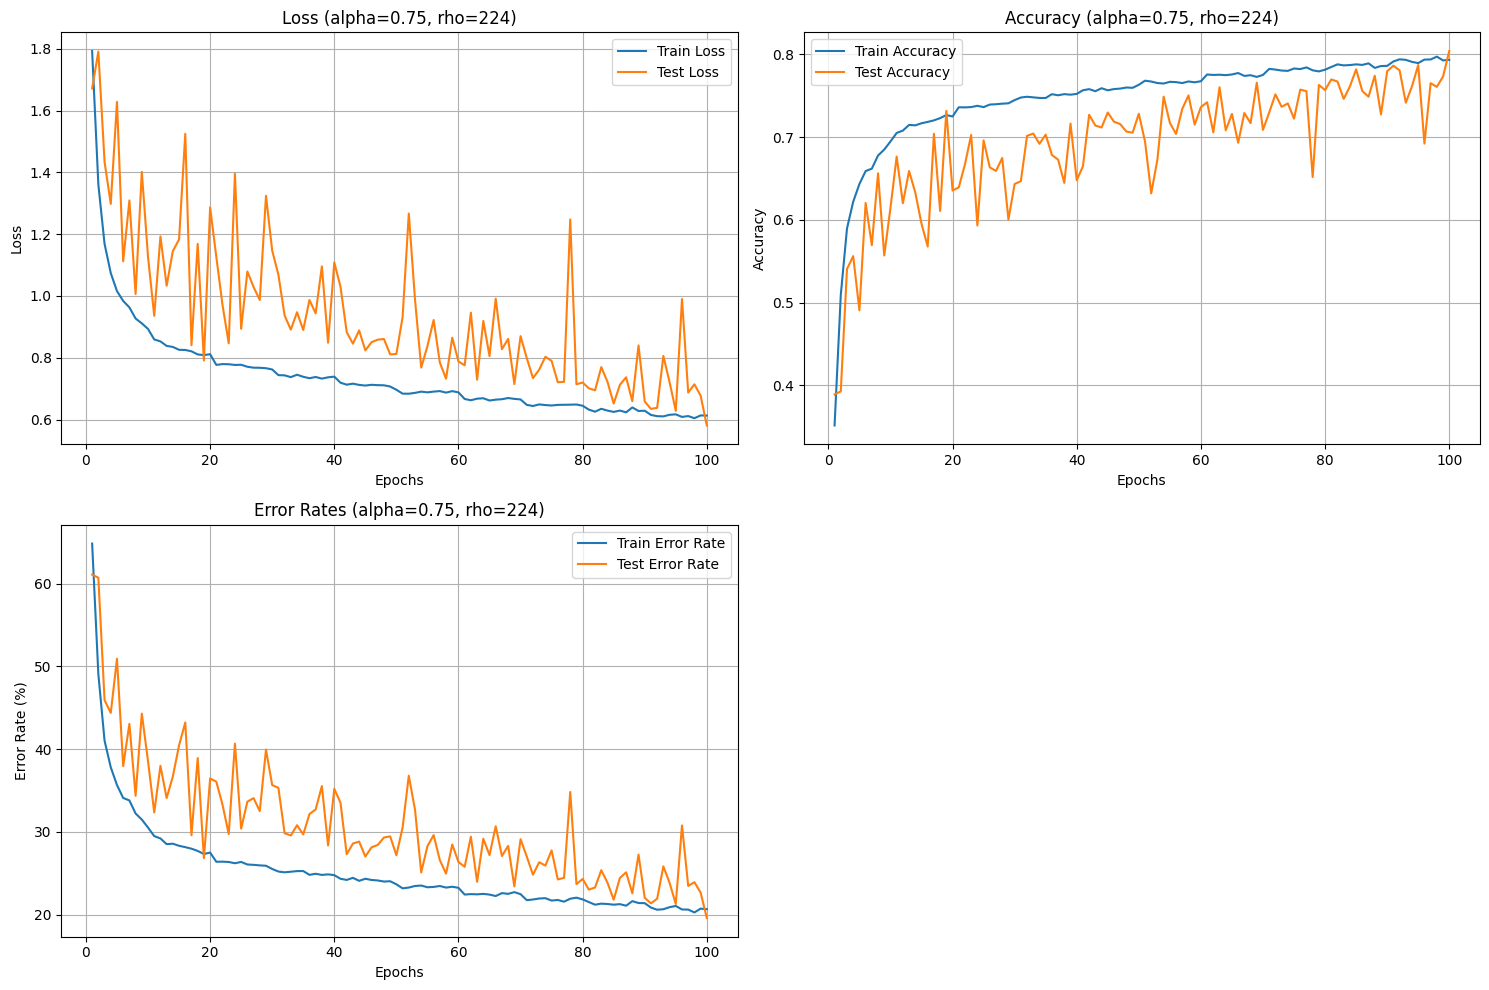

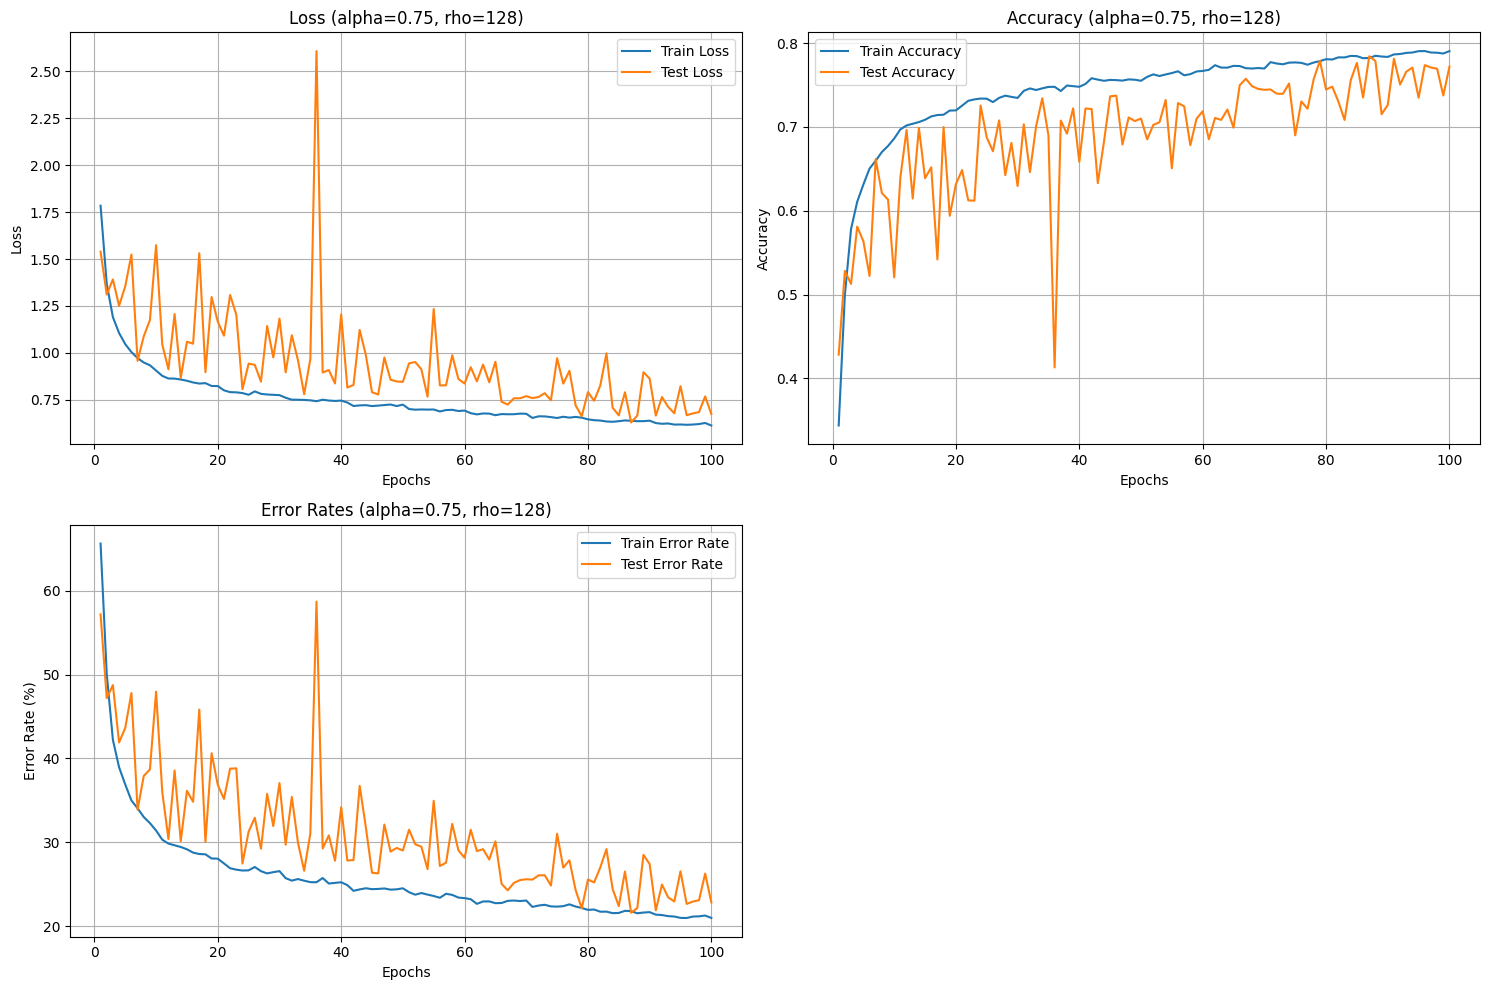

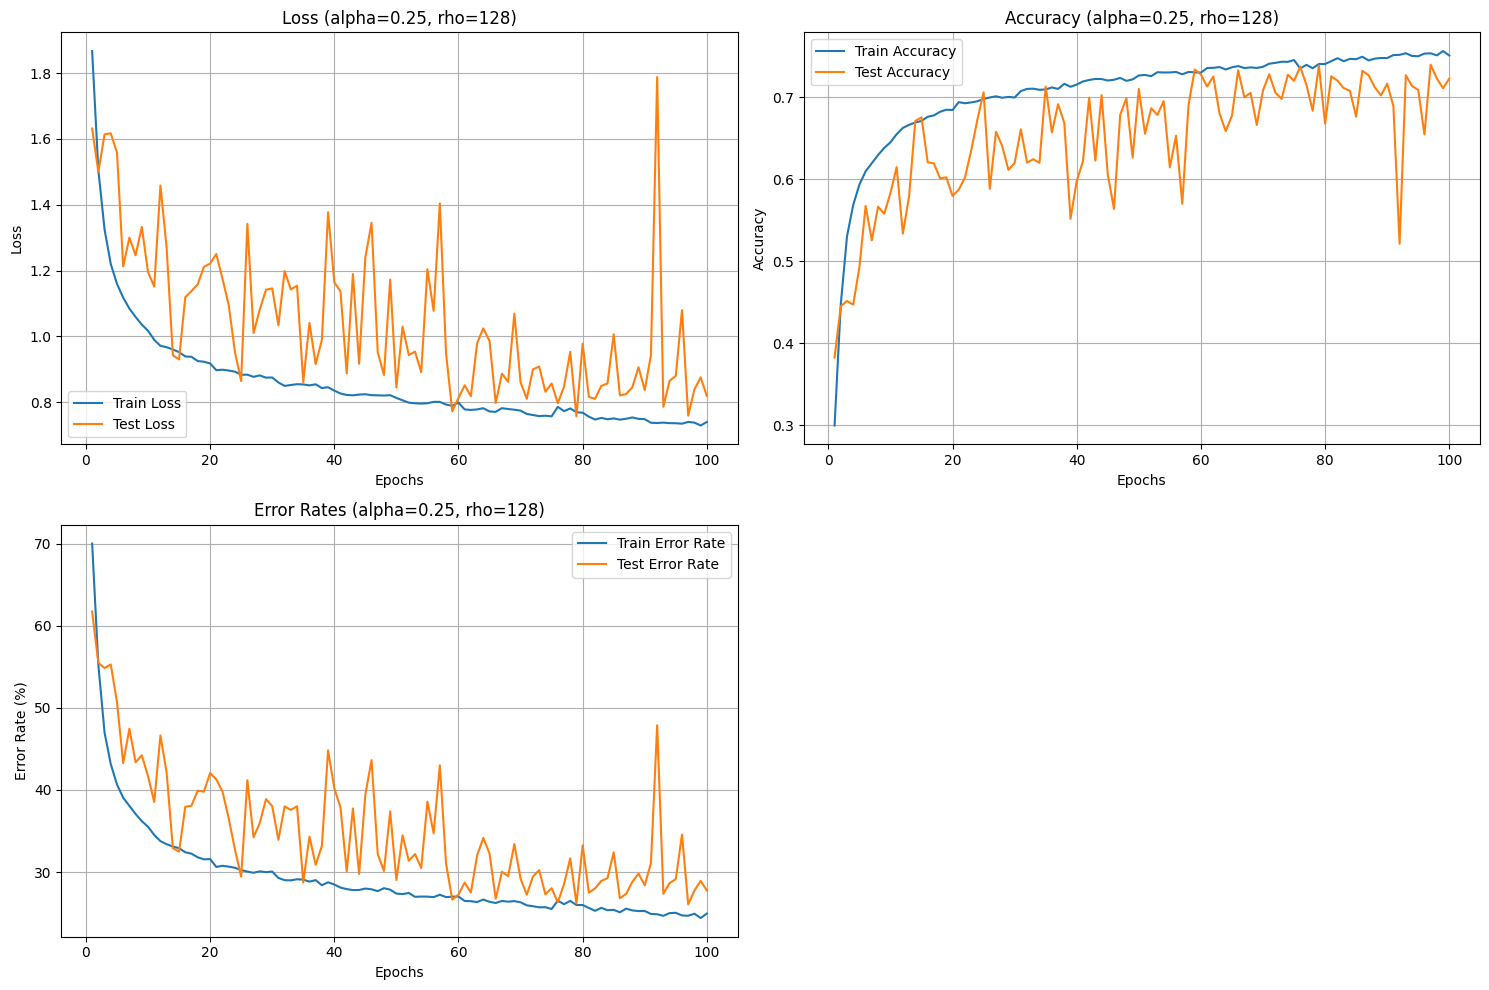

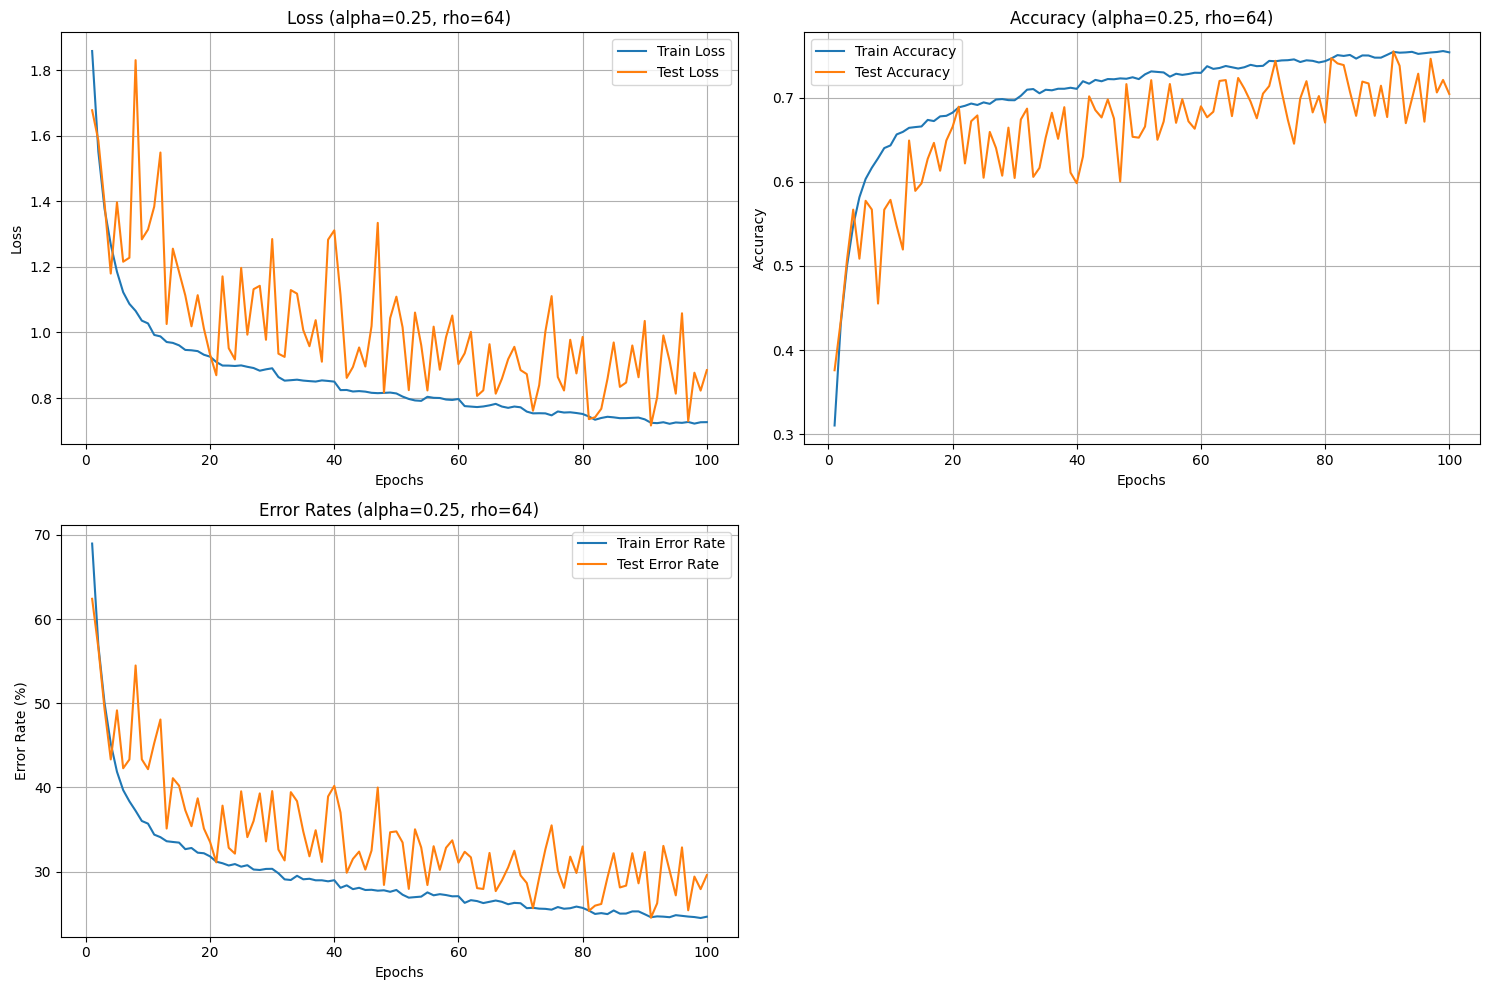

In [19]:
for result in all_experiment_results:
    alpha = result['alpha']
    rho = result['rho']
    loss = result['loss']
    accuracy = result['accuracy']
    train_error_rates = result['train_error_rates']
    test_error_rates = result['test_error_rates']
    
    train_loss, test_loss = zip(*loss)
    train_acc, test_acc = zip(*accuracy)
    
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Loss 그래프
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title(f'Loss (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy 그래프
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title(f'Accuracy (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Train & Test Error Rate 그래프
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_error_rates, label='Train Error Rate')
    plt.plot(epochs, test_error_rates, label='Test Error Rate')
    plt.title(f'Error Rates (alpha={alpha}, rho={rho})')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()